# 1 - Business Understanding

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing, sendo necessário agrupar os clientes em clusters com base em seu comportamento de compra.

Isso irá permitir identificar padrões e características em comum entre os clientes, como:
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.


Os clientes devem ser agrupados levando em consideração o RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


O conjunto de dados fornecido contém transações ocorridas entre dezembro de 2010 e dezembro de 2011.

# 2 - Data Understanding


## Setup

In [ ]:
%pip install yellowbrick

In [83]:
# Data Wrangling
import numpy as np
import pandas as pd
import sidetable

# Visualizacao de dados
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

# Modelos
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

# Validação de modelos
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Deploy
import pickle

In [27]:
# Customização
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

## Dataset

In [28]:
# Carregando a base de dados
df = pd.read_csv('data.csv', encoding='latin1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


## Data Understanding

In [29]:
# Descricão Estatística dos Dados
# Nota-se que existem valores negativos que não fazem sentido, sendo necessária a remoção futura
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [30]:
# Visualização dos tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [31]:
# Verificando dados nulos
# Presença de muitos dados nulos na coluna CustomerID
df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [32]:
# Verificando dados duplicados
df.duplicated().sum()

5268

In [33]:
# Visualizando a quantidade de países e produtos diferentes
df[['Description', 'Country']].nunique()

Description    4223
Country          38
dtype: int64

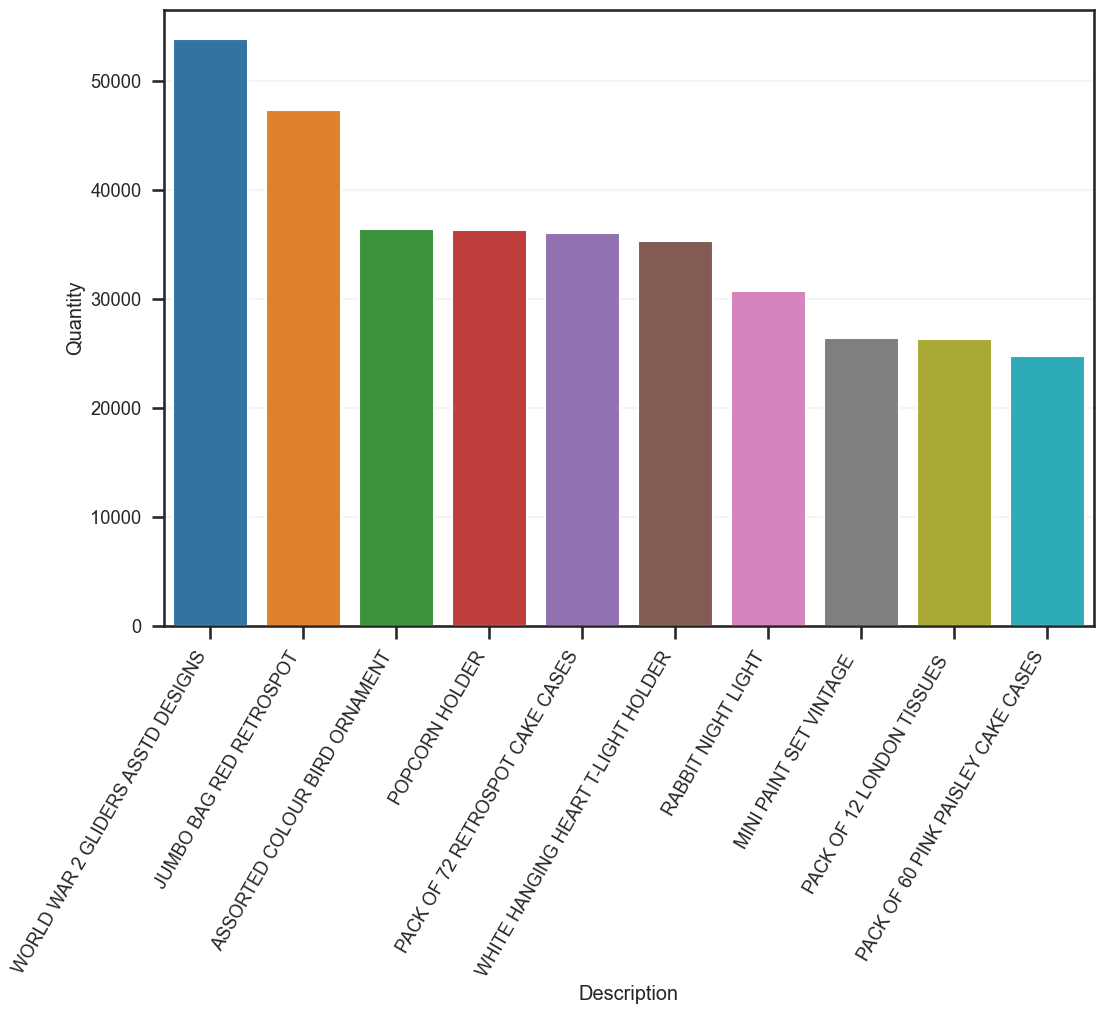

In [34]:
# Visualizando os produtos mais vendidos
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=top_products, x='Description', y='Quantity');
plt.xticks(rotation=60, ha='right');

In [35]:
# Percentual acumulativo dos países
# Cerca de 96% dos dados sao explicados somente pelos 4 primeiros
df.stb.freq(['Country']).head(6)

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523


As principais colunas para análise são:
 - UnitPrice e Quantity para calcular o ticket médio e a frequencia
 - InvoiceDate para calcular a recencia
 - CustomerID para saber qual cliente pertence a qual grupo

# 3 - Data Preparation

## Data Cleaning

In [36]:
# Como foi verificado muitos dados nulos na coluna CostumerID, será necessário dropar esses valores
df = df.dropna(subset=['CustomerID'])

In [37]:
# Verificando novamente os nulos
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [38]:
df = df.copy()

In [39]:
# Transformando a coluna InvoiceDate para o formato de data
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [40]:
# Transformando a coluna CustomerID para inteiro e Country para Categoria
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

In [41]:
# Conferindo os tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 23.7+ MB


In [42]:
# Removendo Valores Negativos das Colunas Quantity e UnitPrice
df = df.query('Quantity > 0 and UnitPrice > 0')

<Axes: >

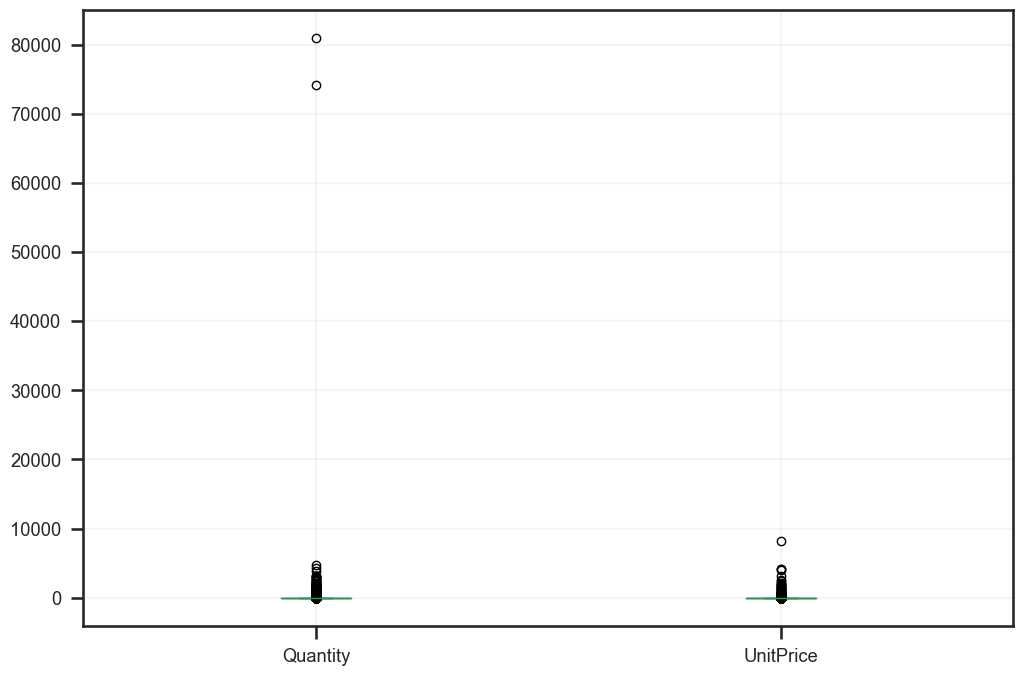

In [43]:
# Verificando Outliers
df[['Quantity', 'UnitPrice']].plot.box()

In [44]:
# Verificando os outliers extremos da quantidade (> 10000)
df.query('Quantity > 10000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


<Axes: >

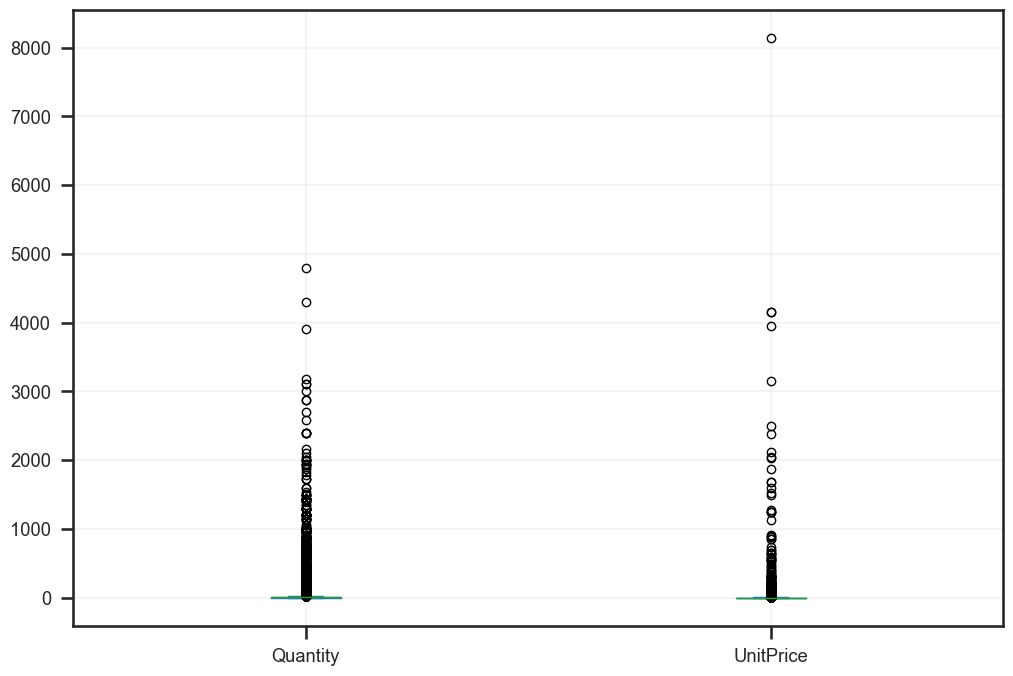

In [45]:
# Plotando novamente sem o outlier da quantidade
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [46]:
# Verificando os outliers extremos do preco (> 8000)
df.query('UnitPrice > 8000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [47]:
# Removendo os Outliers das duas colunas
df = df.query('Quantity<10_000 & UnitPrice<8_000')

## RFM

In [48]:
# Calculando a coluna de preco total
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [49]:
# Calculando o RFM
# Recencia - foi considerado a data 01/01/2012 como o dia 'atual', pois os dados sao de 2011
# Frequencia - o número de compras feito por cada usuário (sem considerar quantidade de itens)
# Ticket Medio - média da coluna TotalPrice

df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


<Axes: >

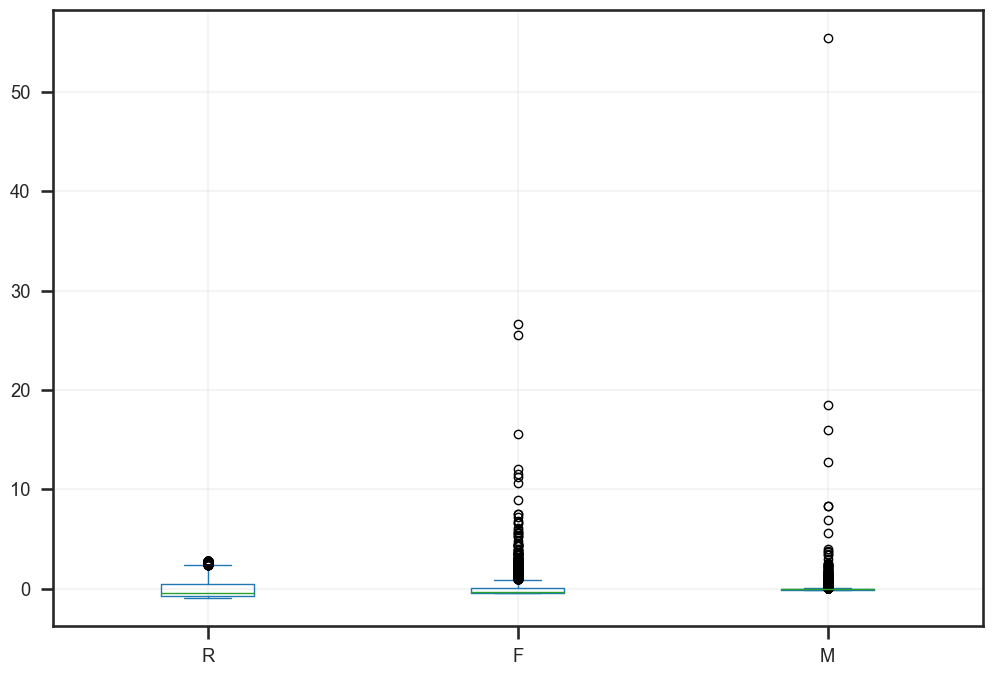

In [50]:
# Visualizando outliers do RFM
df_rfm.apply(scale).plot.box()

In [51]:
# Verificando os percentis
df_rfm.describe(percentiles=[.25, .5, .75, .95, .99])

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,114.053032,4.272308,37.614122
std,99.966159,7.697064,239.369450
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.340909
50%,72.000000,2.000000,17.716923
75%,164.000000,5.000000,24.846154
95%,333.000000,13.000000,92.860000
99%,390.640000,30.000000,358.358400
max,395.000000,209.000000,13305.500000


In [52]:
# Como os valores acima do percentil de 95% variam muito para a frequencia e ticket medio, vou limitá-los até 95% apenas para minimizar os outliers
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe(percentiles=[.25, .5, .75, .95])

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,112.269311,3.608024,23.705198
std,95.503726,3.358625,21.195047
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.340909
50%,72.000000,2.000000,17.716923
75%,164.000000,5.000000,24.846154
95%,333.000000,13.000000,92.732000
max,333.000000,13.000000,92.860000


<Axes: >

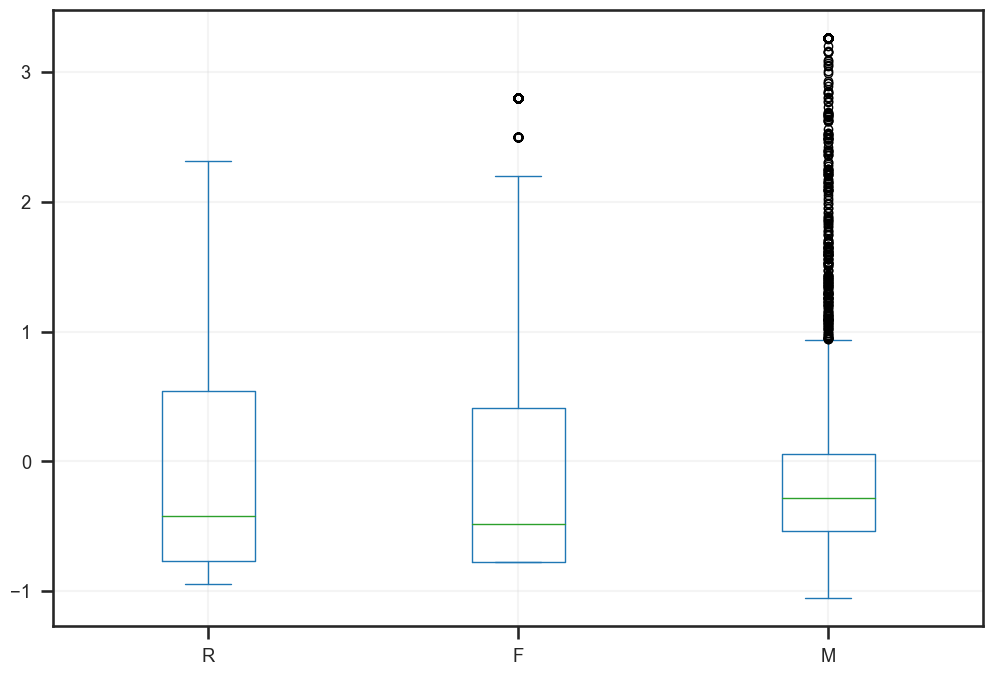

In [53]:
# Aplicando a escala para padronizar os dados e plotando o boxplot
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
df_rfm_clip_scaled.plot.box()

# 4 - Modeling / Evaluation

A fim de comparação, será utilizado o Kmeans e a Clusterização Hierarquica

## KMeans

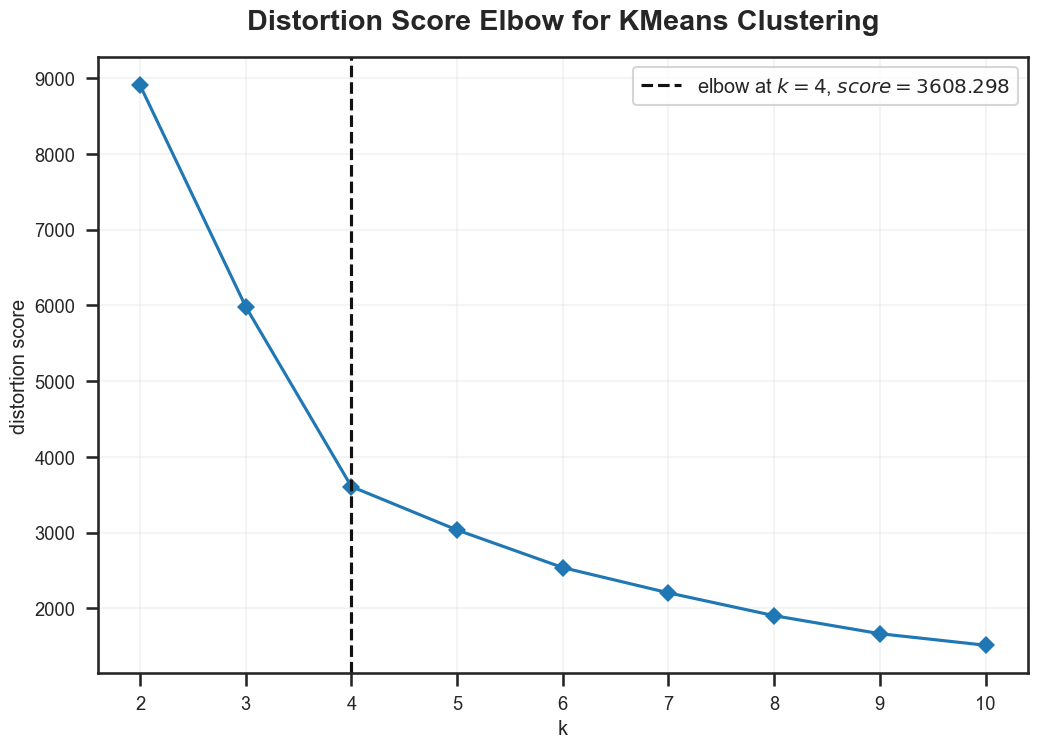

In [54]:
# Selecionando a quantidade de clusters a partir do método Elbow
kelbow_visualizer(KMeans(n_init=10), df_rfm_clip_scaled, k=10, timings=False);

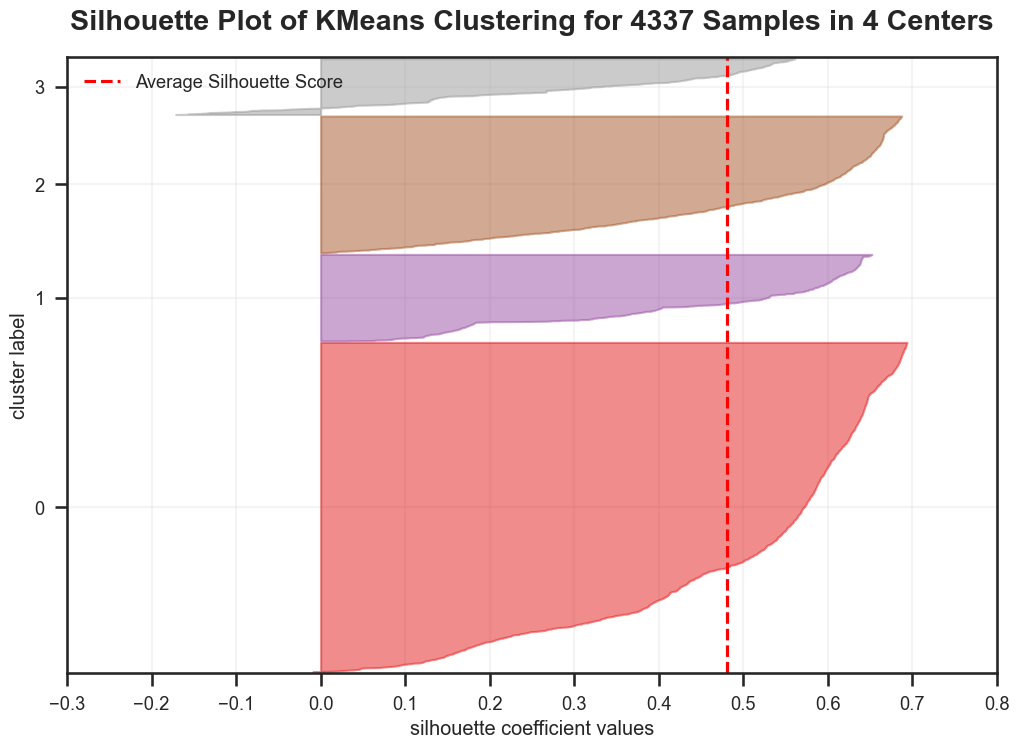

In [84]:
# silhouette_visualizer
silhouette_visualizer(KMeans(n_clusters=4, n_init=10), df_rfm_clip_scaled);

In [55]:
# Selecionando a quantidade de clusters a partir das métricas Silhouette, Davies Bouldin e Calinski para comparação

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, n_init=10, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8908.418406,0.382988,1.064856,1996.406529
3,5984.365254,0.434510,0.858817,2544.416466
4,3608.298496,0.480126,0.704045,3763.722769
5,3096.916055,0.386757,0.852877,3466.984802
6,2538.466349,0.398528,0.851342,3573.539059
7,2205.111681,0.377014,0.868977,3536.449378
8,1905.099584,0.383953,0.864325,3605.169088
9,1665.786505,0.394546,0.802939,3684.618315
10,1513.392626,0.352180,0.889081,3652.584285


In [56]:
# Como visto nos dois métodos, levando em consideração principalemnte Elbow e Silhouette, a quantidade de clusters será 4

kmeans = KMeans(4, n_init=10)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)


In [57]:
# Plotando os clusters identificados pelo modelo
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

In [80]:
px.scatter(df_rfm_clip, x='R', y='F', color=kmeans_labels.astype(str), template='plotly_dark')

## Hierarchical Clustering

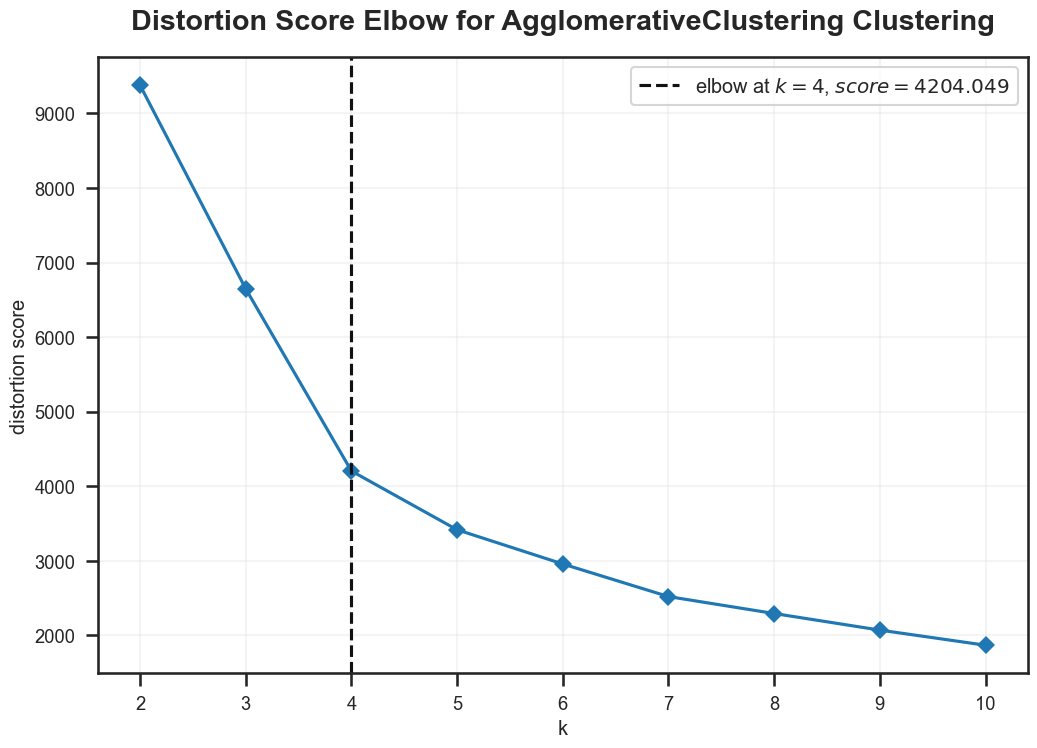

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [58]:
# Selecionando a quantidade de clusters a partir do método Elbow
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [59]:
# Selecionando a quantidade de clusters a partir das métricas Silhouette, Davies Bouldin e Calinski para comparação
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.331367,1.141649,1678.740370
3,0.385448,0.982635,2074.147986
4,0.418680,0.847537,3025.696124
5,0.390847,0.872247,3042.019827
6,0.398076,0.781907,2944.970410
7,0.404861,0.859205,3004.967459
8,0.356787,0.904265,2891.465304
9,0.360068,0.849300,2859.368212
10,0.278053,0.979225,2869.541149


In [60]:
# Apesar do score de Davies Bouldin sugerir 2 clusters, os outros indicam 4 clusters. Portanto será utilizado 4
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [61]:
# Plotando os clusters identificados pelo modelo
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str),  template='plotly_dark')

# 5 - Interpretation of Clusters - KMeans

Os dois modelos apresentaram divisões muito parecidas nos clusters, portanto qualquer um dos dois modelos explicaria de forma satisfatória a divisão de clusters.
Foi utilizado como base para a interpretação dos dados o modelo do Kmeans.

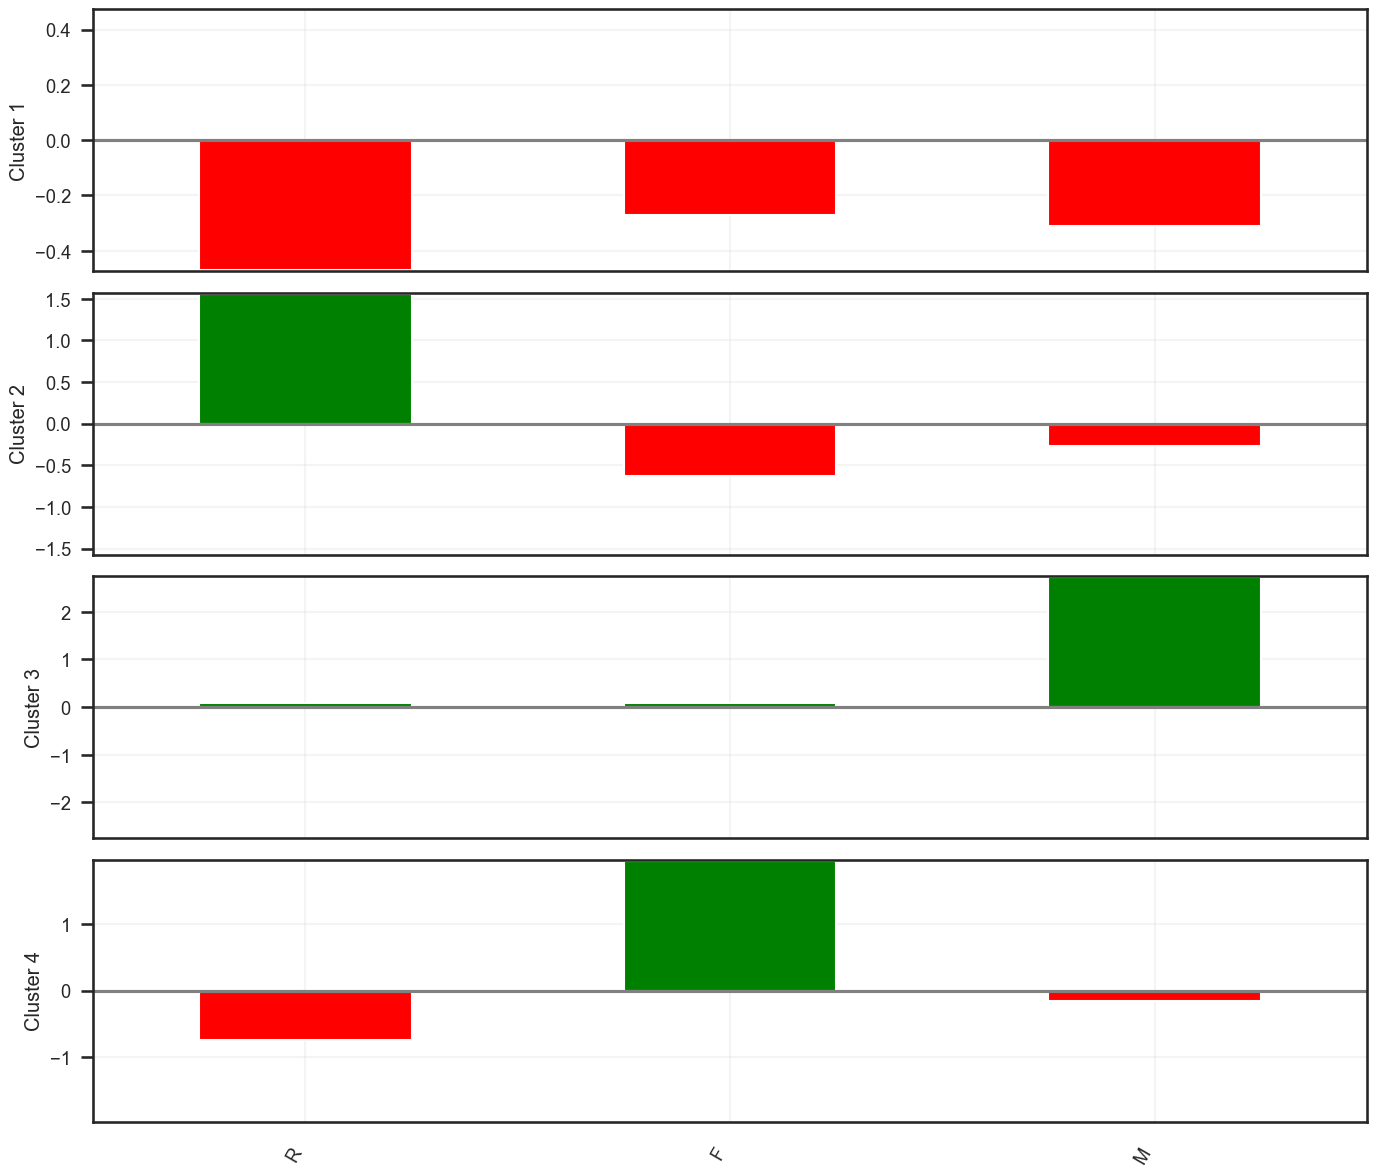

In [62]:
# Plotando as características de cada cluster de clientes

centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [63]:
(
  df_rfm_clip.assign(cluster=kmeans_labels+1)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,1,2,3,4
R,67.523221,261.082051,121.266332,41.517018
F,2.703877,1.509744,3.874372,10.191248
M,17.120301,18.104189,81.339370,20.426973


Relembrando:

- Recencia - foi considerado a data 01/01/2012 como o dia 'atual', pois os dados sao de 2011
- Frequencia - o número de compras feito por cada usuário (sem considerar quantidade de itens)
- Ticket Medio - média da coluna TotalPrice


Observando os gráficos e a figura acima, pode-se observar as seguintes caracteristicas para cada grupo:

- Cluster 1: Clientes que possuem um alto ticket médio, não fizeram compras recentes e fazem pedidos com frequencia moderada na loja, mais frequente que os clusters 3 e 4;
  
- Cluster 2: Clientes que compram com uma alta frequencia na loja, mas não possuem um ticket médio alto. A recencia é baixa, indicando que fizeram compras recentes na loja;
  
- Cluster 3: Clientes que possuem recencia alta, ou seja, nao compram faz muito tempo, além de ticket médio e frequencia baixa. Compraram poucas vezes, produtos não muito caros e faz tempo que não compram novamente. Provavelmente são clientes Churn;
  
- Cluster 4: Clientes que fizeram compras recentes na loja, mas não compram muitos produtos, tanto no quesito de frequencia quanto de ticket médio.


A partir da divisão desses clusters, é possível definir estratégias diferentes de abordagem para cada caso, focando nas características principais de cada grupo.

- Os clientes do cluster 1 poderiam ter ofertas especiais nos produtos que geralmente compram, pois eles compram em grande quantidade e não é vantajoso perder clientes desse nível. Dessa forma merecem um desconto especial;

- Para os clientes do cluster 2 e 4, a recencia já é bem baixa, portanto apenas anúncios atrativos a fim de reter o cliente em produtos de maior valor devem ser o suficiente;

- Já os clientes do grupo 3, que não realizam compras faz tempo, é possível mandar um email perguntando o motivo de não comprarem mais para posteriormente fazer uma campanha com foco em reaver tais clientes.

# 6 - Deployment

In [64]:
with open('C:\DNC\Python\Prova 4\Models\model', 'wb') as model_file:
    pickle.dump(kmeans, model_file)